# **Exercise Sheet 4: Deep Learning on Sets and Graphs**

In [220]:
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from torch import nn, FloatTensor
from torch.optim import Adam
from torch.nn import Linear, ModuleList, ReLU, Sigmoid, Sequential
import torch.nn.functional as F
import torch

## **Exercise 4-1** *Invariant functions and permutation groups*

A function $f:\mathbb{R}^n \rightarrow Y$ is said to be invariant to a subgroup $G$ of the symmetric group $S_n$ if for all $\pi$ in $G$

$$f(\pi(x)) = f(x)\ for\ all\ x \in \mathbb{R}^n,$$

where $\pi(x_1,x_2,\dots,x_n) = (x_{\pi(1)},x_{\pi(2)},\dots,x_{\pi(n)})$. A set of permutations $P$ together with the composition of functions denoted by $\circ$ is a permutation group if

 - $P$ is closed under composition, i.e., for all $\pi,\sigma$ in $P$ the permutation $\pi \circ \sigma$ is in $P$,
 - the identity permutation $i \rightarrow i$ for $i$ in $\{1,2,\dots,n\}$ is in $P$, and
 - for all $\pi$ in $P$ the inverse $\pi^{-1}$ is in $P$.

Let $P \subseteq S_n$ be a set of permutations and $f:\mathbb{R}^n \rightarrow Y$ be a function that satisfies the Equation above for all $\pi$ in $P$. Show
that there is a set $G$ with $P \subseteq G \subseteq S_n$ such that $G$ forms a permutation group and $f$ is invariant to $G$.

Let us assume that subset $G$ only contains the smallest possible subset $P$ that is also a permutation group, therefore only containing the identity permutation.

This would fulfill the property that $\pi \circ \sigma$ is in $P$, since $\pi_{identity} \circ \pi_{identity} = \pi_{identity}$.

This would also fulfill the property, that the identity permutation is in $P$, the proof of this is trivial.

Finally this would fulfill the property that for all $\pi$, $\pi^{-1}$ is in $P$, since $\pi(x) = \pi(\pi(x)) = x$

Therefore $P$ is a permutation group.

Since $G$ only contains $P$, we need only to look at the identity permutation in order to prove that $f$ is invariant to $G$.

Since $\pi_{identity}(x) = x$, we can conclude, that $f(\pi(x)) = f(x)\ \forall x \in \mathbb{R}^n$, making $f$ invariant to $G$.

## **Exercise 4-2** *Implementation of set functions*
Consider the ground truth function $g : \{0,1,\dots,9\}^{10} \rightarrow \{-1,+1\}$ with

$$g(x) = \begin{cases}
            +1 \text{ if there are distinct i, j, k} \in \{1,\dots,10\} with\ x_i+x_j+x_k = 5 \\
            -1\ otherwise
          \end{cases}$$
We would like to learn the function from training data using a neural network.

### **a)** *Write code to create a dataset with class labels according to the function $g$. The ten components of each data point should be drawn uniformly at random from $\{0,1,\dots,9\}$. The number of data points can be adjusted for the later tasks.*

In [169]:
def generate_dataset(size):
    X = np.random.randint(low=0,high=10,size=(size,10))
    y = np.ones(size, dtype=int)
    for index, x in enumerate(X):
        if not any(sum(x[list(indices)]) == 5 for indices in combinations(range(len(point)),3)):
           y[index] = -1
    return X, y

X, y = generate_dataset(20000)



### **b)** *Compute statistics of your dataset (e.g., class balance) and split the data into training and test sets.*

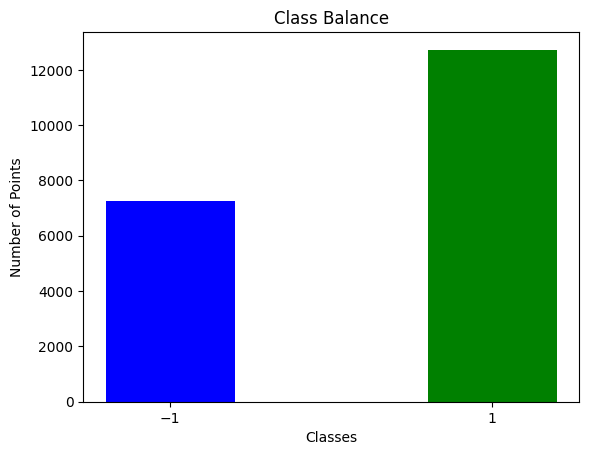

In [170]:
classes, counts = np.unique(y, return_counts=True)
plt.bar(classes, counts, color=['blue','green'])
plt.xticks(classes)
plt.title("Class Balance")
plt.xlabel("Classes")
plt.ylabel("Number of Points")
plt.show()

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=42)

#convert to torch readable format
X_train = FloatTensor(X_train).view(-1, 10)
X_test = FloatTensor(X_test).view(-1, 10)
y_train = FloatTensor((y_train == 1).astype(float)).unsqueeze(1)
y_test = FloatTensor((y_test == 1).astype(float)).unsqueeze(1)

### **c)** *Implement a permutation-sensitive neural network and train and evaluate it using your data set. Try different parameters of your network (e.g., learning rate, hidden dimension, number of layers, activation function) and report your results.*

In [172]:
class PermutationSensitiveNN(nn.Module):
    def __init__(self, hidden_channels=42, hidden_layers=1):
        super(PermutationSensitiveNN, self).__init__()
        self.input_layer = Linear(X.shape[1], hidden_channels)
        self.hidden_layers = ModuleList()
        for _ in range(hidden_layers):
            self.hidden_layers.append(Linear(hidden_channels, hidden_channels))
        self.output_layer = Linear(hidden_channels,1)
        self.activation_func = ReLU()
        self.output_activation = Sigmoid()
    def forward(self, x):
        x = self.activation_func(self.input_layer(x))

        for layer in self.hidden_layers[:-1]:
            x = self.activation_func(layer(x))
        x = self.hidden_layers[-1](x)

        # 2. Apply dropout and a final linear layer
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.output_layer(x)

        return self.output_activation(x)

In [185]:
def train_test(model, X_train, y_train, X_test, y_test, epochs,learning_rates):
    criterion = nn.BCELoss()
    final_accuracies = []
    for lr in learning_rates:
        optimizer = Adam(model.parameters(), lr=lr)
        for epoch in range (1,epochs+1):
            model.train()
            optimizer.zero_grad()
    
            out = model(X_train)
            loss = criterion(out, y_train)
            loss.backward()
            optimizer.step()
    
            model.eval()
            
            with torch.no_grad():
                out = model(X_test)
                test_acc = ((out > 0.5) == y_test).float().mean().item()
                out = model(X_train)
                train_acc = ((out > 0.5) == y_train).float().mean().item()
        final_accuracies.append((train_acc,test_acc))
    return final_accuracies

In [203]:
learning_rates = [0.02, 0.01, 0.001]
print("-----Hidden Layers-----Learning Rate-----Train Accuracy-----Test Accuracy-----")
for layers in range(1,5+1):
    model = PermutationSensitiveNN(hidden_channels=42, hidden_layers=layers)
    #490
    accuracies = train_test(model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=490, learning_rates=learning_rates)
    for lr, (train_acc, test_acc) in zip(learning_rates, accuracies):
        print(f"\t   {layers}\t\t    {lr}\t     {train_acc:.4f}\t\t{test_acc:.4f}")
    

-----Hidden Layers-----Learning Rate-----Train Accuracy-----Test Accuracy-----
	   1		    0.02	     0.8486		0.8453
	   1		    0.01	     0.8503		0.8468
	   1		    0.001	     0.8515		0.8453
	   2		    0.02	     0.8505		0.8378
	   2		    0.01	     0.8524		0.8425
	   2		    0.001	     0.8534		0.8420
	   3		    0.02	     0.8694		0.8472
	   3		    0.01	     0.8798		0.8405
	   3		    0.001	     0.8838		0.8413
	   4		    0.02	     0.8926		0.8183
	   4		    0.01	     0.9201		0.8027
	   4		    0.001	     0.9347		0.7980
	   5		    0.02	     0.8936		0.8158
	   5		    0.01	     0.9149		0.7865
	   5		    0.001	     0.9587		0.7928


### **d)** *Implement a permutation-invariant neural network discussed in the lecture (e.g., Deep Sets, Janossy pooling, Deep Sets with attention) and train and evaluate it using your data set. Try different parameters of your network (e.g., realizations of the functions $\rho$ and $\phi$) and report your results.*

In [229]:
class DeepSet(nn.Module):
    def __init__(self, hidden_channels=42):
        super(DeepSet, self).__init__()
        self.phi = Sequential(
            Linear(X.shape[1], hidden_channels),
            ReLU(),
            Linear(hidden_channels, hidden_channels),
            ReLU(),
        )
        self.rho = Sequential(
            Linear(hidden_channels, hidden_channels),
            ReLU(),
            Linear(hidden_channels, 1),
            Sigmoid()
        )
    def forward(self, x):
        x = self.phi(x)

        x = torch.sum(x, dim=1)

        x = self.rho(x)
        return x


In [238]:
# convert data to 3d space for individual point processing
X_train = X_train.view(-1,10,1)
X_test = X_test.view(-1,10,1)


learning_rates = [0.02, 0.01, 0.001]
hidden_channels = [24, 42, 56, 69, 96]
print("-----Hidden Channels-----Learning Rate-----Train Accuracy-----Test Accuracy-----")
for channels in hidden_channels:
    model = DeepSet(hidden_channels=channels)
    #490
    accuracies = train_test(model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=490, learning_rates=learning_rates)
    for lr, (train_acc, test_acc) in zip(learning_rates, accuracies):
        print(f"\t   {channels}\t\t    {lr}\t     {train_acc:.4f}\t\t{test_acc:.4f}")

-----Hidden Channels-----Learning Rate-----Train Accuracy-----Test Accuracy-----
	   24		    0.02	     0.8970		0.8980
	   24		    0.01	     0.8970		0.8980
	   24		    0.001	     0.8986		0.9020
	   42		    0.02	     0.8988		0.9010
	   42		    0.01	     0.9107		0.9103
	   42		    0.001	     0.9230		0.9212
	   56		    0.02	     0.8781		0.8785
	   56		    0.01	     0.8978		0.9020
	   56		    0.001	     0.8955		0.8980
	   69		    0.02	     0.8962		0.8982
	   69		    0.01	     0.9020		0.9000
	   69		    0.001	     0.9059		0.9047
	   96		    0.02	     0.6367		0.6348
	   96		    0.01	     0.6367		0.6348
	   96		    0.001	     0.6367		0.6348


### **e)** *Discuss whether your results in tasks **c)** and **d)** meet your expectations. Give reasons for your answer.*

While I did expect a Test accuracy of around 0.8 to 0.85 for **c)**, I did not expect that the accuracy would fall when using 4 or more layers (although this could be attributed to the amount of epochs, since neither train nor Test accuraccy are almost 1.0).

I expected that, since the hypothesis class did grow larger, I would get better overall results, therefore my expectations weren't met.

I also expected slower learning rates to give better Test Accuracy for the neural network, which also wasn't the case, since my best value was when the learning rate was 0.02.

In regad to **d)** my expectation that a slower learning rate, leads to a better result was met, as I got my best results with a learning rate of 0.001.

However, the expectation, that if I increase the hidden channels (or nodes per hidden layer), I get better results, were not met, since I got the worst Test Accuracy with 96 hidden channels.

The reason why I expected a slower leraning rate to be more effective, was, that I thought I would jump over the better local optimum otherwise, but it seems to only be relevant for the deep set, maybe there aren't that many local optima for the "normal" neural network.

The reason why I thought increasing the hidden channels might help, was again to increase the hypothesis class, but maybe that would again have needed a lot more epochs.